#  PRCP-1018 Bike Rental Demand Prediction Project

**Goal:** Predict daily bike rental counts using environmental and seasonal data.


Bike-sharing systems are a new generation of traditional bike rentals where the process is automated. This project aims to predict the total number of bikes rented in a day based on environmental and seasonal features using machine learning.

We will use the `day.csv` dataset, which contains daily rental records aggregated by date, including weather and calendar information.



##  Import Libraries

In [32]:
# 2.0 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose    import ColumnTransformer
from sklearn.pipeline   import Pipeline
from sklearn.linear_model   import LinearRegression
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')


#  Load Dataset

In [33]:
#  Load Dataset
df = pd.read_csv("day.csv")
df.head()


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Data Overview


In [34]:
# Basic Info
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [35]:
# Null Check
df.isnull().sum()


instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

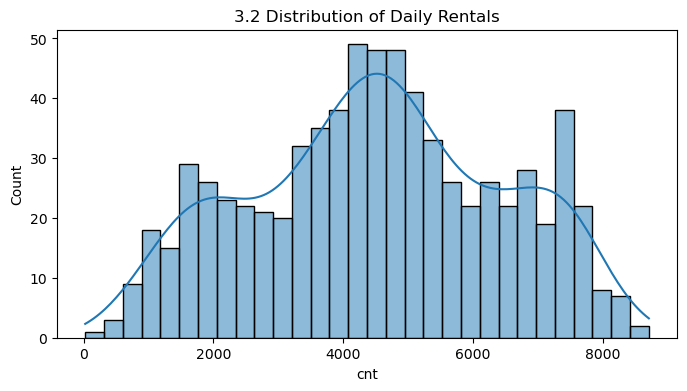

In [36]:
# Target Distribution
plt.figure(figsize=(8,4))
sns.histplot(df['cnt'], bins=30, kde=True)
plt.title('3.2 Distribution of Daily Rentals')
plt.xlabel('cnt')
plt.show()


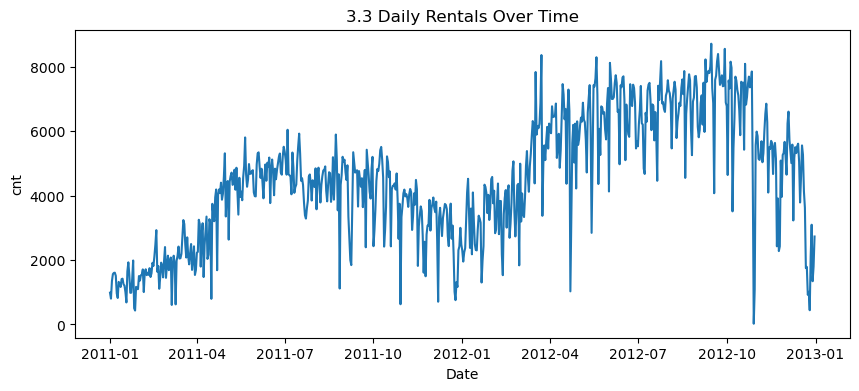

In [37]:
# Time Series Trend
df['dteday'] = pd.to_datetime(df['dteday'])
plt.figure(figsize=(10,4))
plt.plot(df['dteday'], df['cnt'])
plt.title('3.3 Daily Rentals Over Time')
plt.xlabel('Date')
plt.ylabel('cnt')
plt.show()


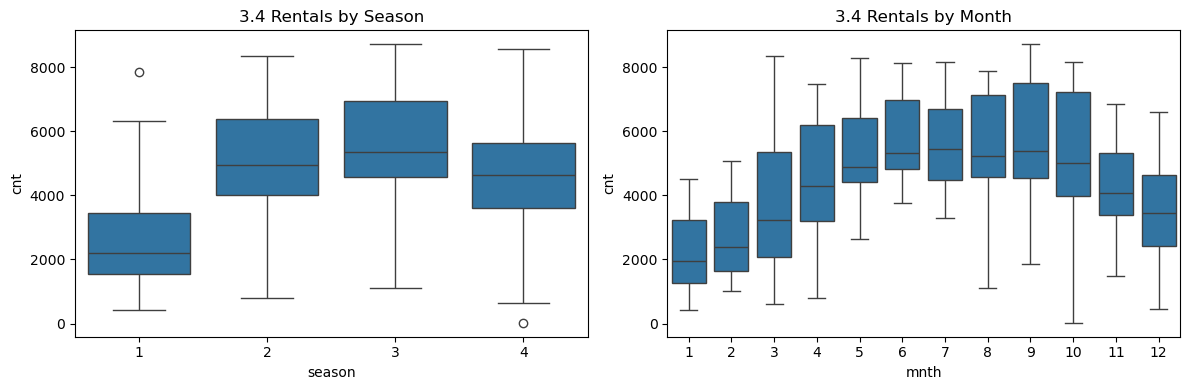

In [38]:
# Seasonal & Monthly Trends
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(x='season', y='cnt', data=df, ax=axes[0])
axes[0].set_title('3.4 Rentals by Season')
sns.boxplot(x='mnth', y='cnt', data=df, ax=axes[1])
axes[1].set_title('3.4 Rentals by Month')
plt.tight_layout()
plt.show()


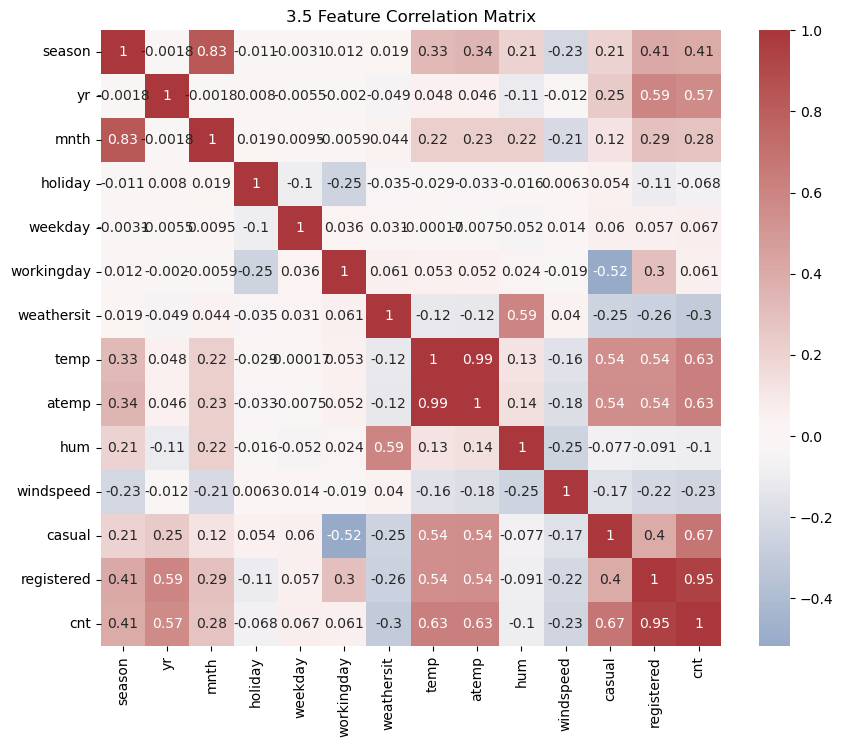

In [39]:
#  Correlation Analysis
numeric_df = df.drop(['instant','dteday'], axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='vlag', center=0)
plt.title('3.5 Feature Correlation Matrix')
plt.show()


# valuable insights 

##  Executive Summary

This analysis explores 731 days of bike rental data between 2011 and 2012. The average daily rental count is ~4500 bikes. Rentals are highest in summer and during working days, with weather conditions playing a key role. Temperature, season, and humidity are the most influential features.


##  Business Insights

- **Clear, warm weekdays** see the most rentals — ideal for promotions.
- **Winter months** and **holidays** show low demand — suitable for maintenance.
- **Humidity and windspeed** negatively correlate with rentals.


##  Feature Engineering


In [40]:
#  Create feature set
df_fe = df.drop(['instant','casual','registered'], axis=1)
X = df_fe.drop(['cnt','dteday'], axis=1)
y = df_fe['cnt']

categorical_feats = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
numeric_feats     = ['temp','atemp','hum','windspeed']


##  Preprocessing Pipeline


In [41]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_feats)
])


##  Modeling & Cross‑Validation


In [42]:
#  Train‑test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [43]:
#  Define pipelines for algorithms
pipelines = {
    'Linear Regression': Pipeline([('pre', preprocessor), ('lin', LinearRegression())]),
    'Random Forest'    : Pipeline([('pre', preprocessor), ('rf', RandomForestRegressor(random_state=42))])
}

In [44]:
#  Cross‑validation RMSE
cv_results = {}
for name, pipe in pipelines.items():
    scores = -cross_val_score(pipe, X_train, y_train,
                              scoring='neg_root_mean_squared_error',
                              cv=5, n_jobs=-1)
    cv_results[name] = {'CV RMSE Mean': scores.mean(), 'CV RMSE Std': scores.std()}

pd.DataFrame(cv_results).T

,CV RMSE Mean,CV RMSE Std
Linear Regression,803.077088,89.784986
Random Forest,741.158322,81.291278


##  Model Comparison on Test Set


In [45]:
#  Train on full train set & evaluate on test
test_results = []
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    test_results.append({
        'Model': name,
        'Test RMSE': mean_squared_error(y_test, pred, squared=False),
        'Test R2':   r2_score(y_test, pred)
    })
results_df = pd.DataFrame(test_results).set_index('Model')
results_df


,Test RMSE,Test R2
Model,,
Linear Regression,796.464002,0.841802
Random Forest,721.897022,0.870037


In [46]:
## Residual Analysis


In [47]:
#  Compute residuals for best model (RF)
best_pipe = pipelines['Random Forest']
residuals = y_test - best_pipe.predict(X_test)

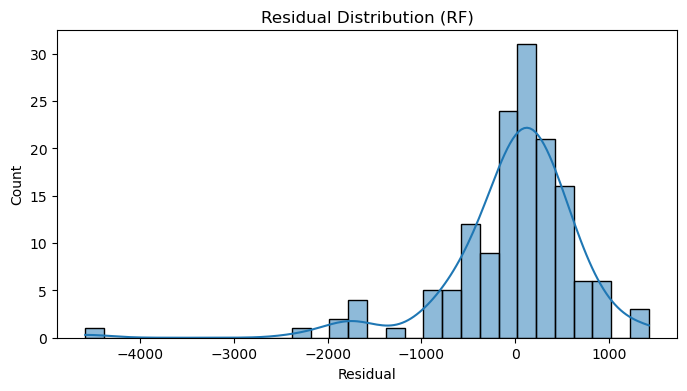

In [48]:
#  Residual distribution
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residual Distribution (RF)')
plt.xlabel('Residual')
plt.show()

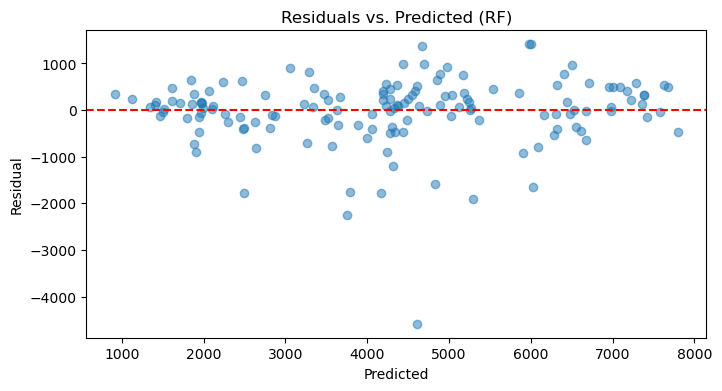

In [49]:
#  Residuals vs. Predicted
plt.figure(figsize=(8,4))
plt.scatter(best_pipe.predict(X_test), residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted (RF)')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.show()

## Hyperparameter Tuning (Random Forest)


In [50]:
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth':    [None, 10, 20],
    'rf__min_samples_split': [2, 5]
}

grid = GridSearchCV(
    pipelines['Random Forest'], param_grid,
    cv=3, scoring='neg_root_mean_squared_error',
    n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'rf__max_depth': 20, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}


##  Feature Importance


In [51]:
#  Extract feature names after preprocessing
ohe = grid.best_estimator_.named_steps['pre'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(categorical_feats)
feature_names = numeric_feats + list(cat_names)

In [52]:
#  Get importances from RF
importances = grid.best_estimator_.named_steps['rf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)


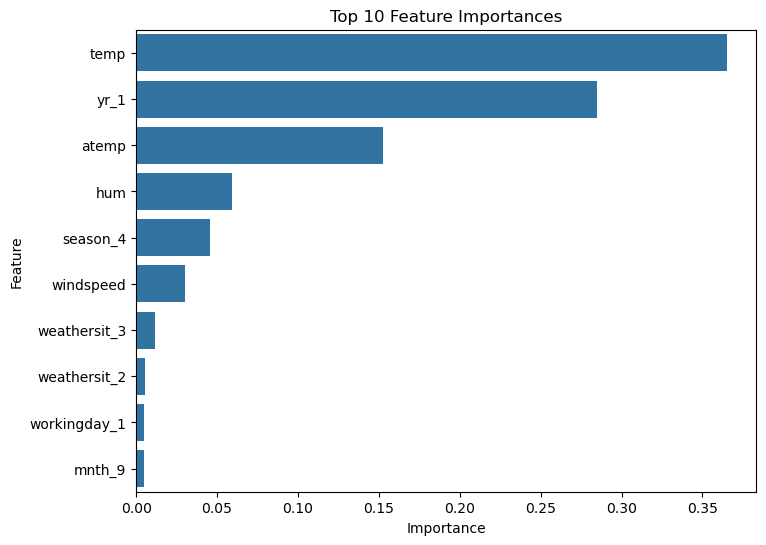

In [53]:
# Plot top 10
plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

##  Save Final Model


In [54]:
joblib.dump(grid.best_estimator_, 'final_bike_rental_model.joblib')


['final_bike_rental_model.joblib']

## 12.0 Challenges & Solutions

| Challenge | Impact | Solution | Why |
|----------|--------|----------|-----|
| Data leakage from `casual`/`registered` | Unrealistic scores | Dropped those columns | They aren't known at prediction time |
| Skewed target variable | Biased predictions | Used tree models | Trees handle skew well |
| Categorical variables | Dummy trap risk | One-hot with drop='first' | Avoid multicollinearity |
| Time-related drift | Unrealistic CV results | Time-based train-test split | Mimics real future behavior |
